In [150]:
import os
import torchvision

from torch import cuda, device, Tensor, save, load, stack, zeros, vstack
from src.plots import plot_vae_training_result, plot_image, plot_image_label_two
from src.vae.mnist_vae import ConditionalVae
from src.image_classifier.image_classifier import MNISTClassifier
from src.utils import frechet_inception_distance
from src.sampling import split_dirichlet

device = device('cuda' if cuda.is_available() else 'cpu')

torch.Size([60000, 28, 28])
torch.Size([60000])
[1138, 0, 1130, 6129, 0, 0, 4307, 0, 5685, 0]
18389
[993, 6741, 0, 1, 5841, 5346, 251, 0, 7, 57]
19237
[572, 0, 4827, 0, 0, 1, 0, 4, 114, 5891]
11409
[3220, 1, 0, 1, 1, 73, 1360, 6261, 45, 0]
10962


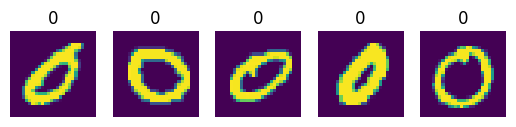

In [165]:
training_data = torchvision.datasets.MNIST(root='../data/MNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.MNIST(root='../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

# input = training_data.data[:60000] / 255.0    # normalizing necessary to make pixels in [0, 1] range for FID
input = training_data.data[:60000]
labels = training_data.targets[:60000]

# non-IID setting
dirichlet_beta = 0.1
num_users = 4
users_data = split_dirichlet(dataset=training_data, num_users=num_users, is_cfar=False, beta=dirichlet_beta)

total_input = []
total_labels = []
total_counts = []
for user_idx in users_data:
    images = []
    outputs = []
    counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    for data_idx in users_data[user_idx]:
        image = input[int(data_idx)]
        images.append(image)
        label = labels[int(data_idx)]
        outputs.append(label)
        counts[label] +=1
    print(counts)
    print(sum(counts))
    total_input.append(images)
    total_labels.append(outputs)
    total_counts.append(counts)

user_idx = 0
sample_input = total_input[user_idx]
sample_label = total_labels[user_idx]

input_tensor = stack(sample_input)
label_tensor = stack(sample_label)

plot_image_label_two(input_tensor.cpu().detach().numpy(), label_tensor.cpu().detach().numpy())

assert input_tensor.shape[0] == label_tensor.shape[0]

training_data.data = input_tensor
training_data.targets = label_tensor

Finished epoch:  1


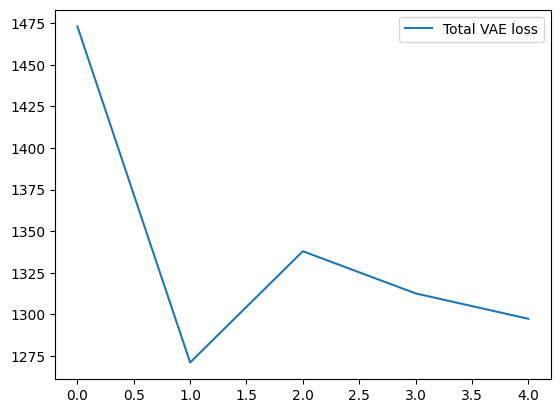

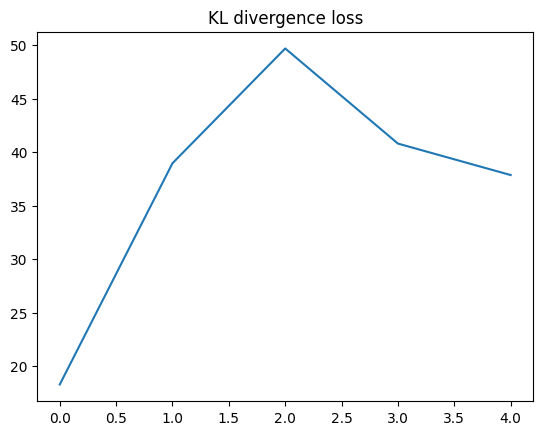

In [166]:
# parameters
model = "cvae"
dataset = "mnist"
batch_size = 32
epoch = 1
learning_rate = 0.01

model_path = f"/home/neo/projects/RP_data/models/{model}_{dataset}_{batch_size}_{epoch}_{learning_rate}_{num_users}_{dirichlet_beta}.pt"

# TODO: save plotting results
if False:
    vae = load(model_path)
else:
    vae = ConditionalVae(dim_encoding=2).to(device)

    # try with model sigma
    vae_model, vae_loss_li, kl_loss_li = vae.train_model(
        training_data=training_data,
        batch_size=batch_size,
        epochs=epoch,
        learning_rate=learning_rate
    )
    save(vae, model_path)
    
    # move tensors to cpu before converting to np array
    np_kl_loss_li = []
    
    for output in kl_loss_li:
        if isinstance(output, Tensor):
            np_kl_loss_li.append(output.cpu().detach().numpy())
    
    # plot results
    plot_vae_training_result(
        input=input,
        labels=labels,
        vae_model=vae_model,
        vae_loss_li=vae_loss_li,
        kl_loss_li=np_kl_loss_li
    )

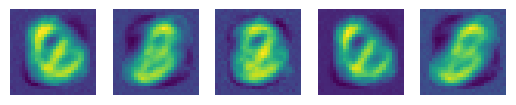

In [169]:
images = vae.generate_data(n_samples=5, target_label=1)
plot_image(images)

In [83]:
# train classifier for performance evaluation
model = "classifier"
dataset = "mnist"
batch_size = 64
epoch = 5

classifier_path = f"/home/neo/projects/RP_data/models/{model}_{dataset}_{batch_size}_{epoch}.pt"

if os.path.exists(classifier_path):
    classifier = load(classifier_path)
else:
    classifier = MNISTClassifier(input_size=784, num_classes=10)
    classifier.train_model(training_data, batch_size=batch_size, epochs=epoch)
    accuracy = classifier.test_model(testing_data)
    print("Test accuracy: ", accuracy)
    save(classifier, classifier_path)

In [84]:
# generate data for testing on classifier
# this one stays the same
data_count = 10000
ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
images = []
labels = []

for label_idx, ratio in enumerate(ratios):
    num_samples_to_generate = int(data_count * ratio)
    images.append(vae.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
    
    label = zeros((num_samples_to_generate, 10), device=device)
    label[:, label_idx] = 1
    labels.append(label.cpu().detach())

final_images = vstack(images)
final_labels = vstack(labels)

assert final_images.shape[0] == final_labels.shape[0]

accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
print("Accuracy: ", accuracy)

Wrong count:  9053
Accuracy:  0.0947


In [ ]:
# # Determine FID
# # generate 500 images
# syn_input, _ = vae.generate_data(n_samples=500)
# input = input[:500]
# 
# input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# 
# # compute FID score
# fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
# print("Frechet Inception Distance: ", fid_score)